# Advanced Lane Finding Project

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import *

import numpy as np

np.set_printoptions(precision = 4)

data_base_dir = "./data"
output_base_dir = "./output"

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Computing camera calibration using chessboard images

In [2]:
from transformation import get_camera_calibration_matrix

ret, cameraMatrix, distCoeffs, rvecs, tvecs =\
                                get_camera_calibration_matrix(6, 9,
                                                              data_base_dir + "/camera_calibration",
                                                              visualize = False)

print("ret:                ", ret)
print("cameraMatrix.shape: ", cameraMatrix.shape)
print("distCoeffs.shape:   ", distCoeffs.shape)
print("len(rvecs):         ", len(rvecs))
print("len(tvecs):         ", len(tvecs))

ret:                 103.11308649883414
cameraMatrix.shape:  (3, 3)
distCoeffs.shape:    (1, 5)
len(rvecs):          17
len(tvecs):          17


## Undistorting test images

In [3]:
from transformation import undistort_images

undistort_images(cameraMatrix, distCoeffs,
                 data_base_dir + "/test_images", visualize = False)

Previously we used canny edge detector to find lane line, canny finds all possibles edges, however lane line are vertically and therefore we can use sobel to find only vertical lines

In [4]:
from transformation import get_perpective_matrices

# points are expected in the format of (x, y) i.e. (cols, rows)
# order of points [tl, tr, br, bl] t: top, b: bottom , r: right, l: left
# float32 is required or else we get error (c compatibility issue)

#src = np.float32([ [575, 464], [738, 464], [1005, 694], [290, 694] ])
#src = np.float32([ [600, 448], [682, 448], [1034, 678], [272, 678] ])

src = np.float32([ [600, 448], [682, 448], [1082, 719], [215, 719] ])
dst = np.float32([ [180, 0], [540, 0], [540, 720], [180, 720] ]) # 25% from left and right 

M, Minv = get_perpective_matrices(src, dst)

./data/test_images/straight_lines1.jpg


<Figure size 1368x576 with 0 Axes>

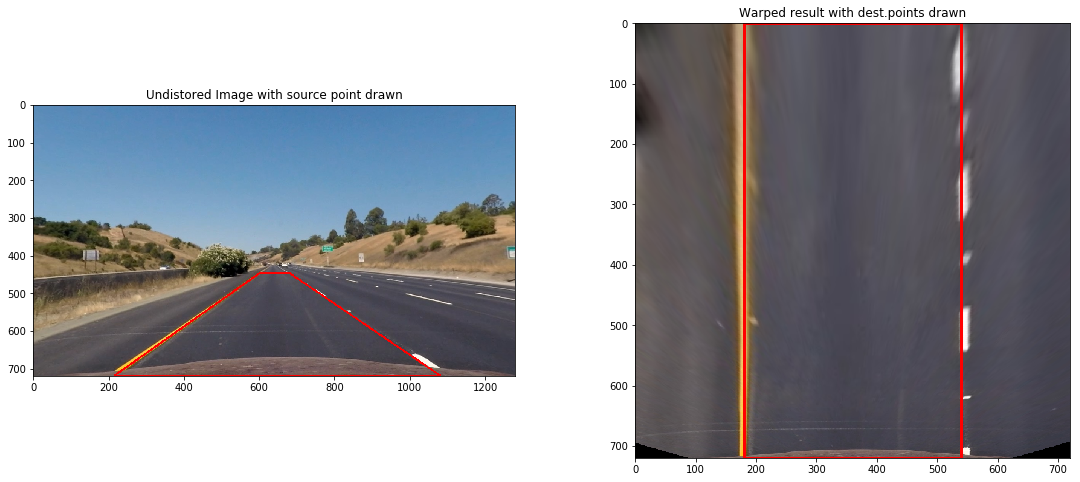

In [5]:
from transformation import warp_image, undistort_image
from utils import *

import glob

for img_fname in glob.glob(data_base_dir + "/test_images/straight_lines1.jpg"):
#for img_fname in glob.glob(data_base_dir + "/test_images/*"):
    print(img_fname)
    img = cv2.imread(img_fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undst = undistort_image(img, cameraMatrix, distCoeffs)
    H, W, _ = undst.shape
    warped = warp_image(undst, (H, H), M)
    cv2.polylines(undst, np.int32([src]), 1, (255, 0, 0), 3)
    cv2.polylines(warped, np.int32([dst]), 1, (255, 0, 0), 3)
    plot_images_along_row([("Undistored Image with source point drawn", undst),
                           ("Warped result with dest.points drawn", warped)])

In [6]:
from thresholding import *
from utils import *

"""
img: RGB image
out: 2D image with pixels set that pass threshold
"""

def get_thresholded_image(img, visualize = False):
    
    thresholded_img = np.zeros_like(img[:, :, 0])
    
    # for white lane
    luv_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    binary_luv = cv2.inRange(luv_img, np.array([225, 0, 0]), np.array([255, 255, 255]))

    # for yellow lane
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    binary_lab = cv2.inRange(lab_img, np.array([0, 0, 150]), np.array([255, 255, 200]))
    
    # this comb adds more robustness for yellow lane
    #hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #binary_hsv = cv2.inRange(hsv_img, np.array([20, 50, 50]), np.array([40, 255, 255]))

    # sometimes white is not detected, therefore we rely on gradient info
    gradx = gradient_thresh(img, orient = "x", thresh = (40, 255), sobel_kernel=3)
    grady = gradient_thresh(img, orient = "y", thresh = (25, 255), sobel_kernel=3)
    
    binary_grad = gradx & grady
    binary_grad_median = median_blur(binary_grad, 3)
    
    #thresholded_img[(binary_hsv > 0) | (binary_luv > 0) | (binary_lab > 0) | (binary_grad_median > 0)] = 255
    thresholded_img[(binary_luv > 0) | (binary_lab > 0) | (binary_grad_median > 0)] = 255
    
    if visualize:
        plot_images_along_row([
            ("Orginal Image", img)
            #, ("HSV", binary_hsv * 255)
            , ("LUV", binary_luv * 255)
            , ("LAB", binary_lab * 255)
            , ("Med Grad", binary_grad_median * 255)
            , ("Merged", thresholded_img)
        ])
    
    return thresholded_img

In [7]:
from transformation import warp_image, undistort_image
from utils import *
from lane_line import *
import cv2

"""
img: RGB image
out: RGB image with lane region colored
"""
def lane_finding_pipeline(imgFrame, frame, visualize = False, log = False):
    isFirstFrame = frame.isFirstFrame
    undst = undistort_image(imgFrame, cameraMatrix, distCoeffs)
    smooth_img = gauss_blur(undst, 5)
    thresholded_img = get_thresholded_image(smooth_img, visualize = visualize)
    H, W = thresholded_img.shape
    binary_warped = warp_image(thresholded_img, (H, H), M)
    #clip = 0.10
    #binary_warped[:, :int(H * clip)] = 0
    #binary_warped[:, int(-H * clip):] = 0
    out_img = process_frame(binary_warped, frame)
    if log:
        print("Lane width: ", frame.laneWidth)
        print("Radius:     ", (frame.leftLane.radius + frame.rightLane.radius) / 2)
        print("Car Dist:   ", frame.distanceFromLaneCenter)
    canvas_warped = draw_lane(binary_warped, frame)
    canvas_unwarped = warp_image(canvas_warped, (W, H), Minv)
    result = overlay_lane_region(undst, canvas_unwarped)
    result = write_lane_data(result, frame)

    if visualize:
        if isFirstFrame:
            plt.plot(frame.histogram["curve"])
            plt_img = get_plot_as_np_array(plt, display_axis = False)
            title = "Histogram of thresholded_image"
        else:
            plt.plot(frame.leftLane.X, frame.leftLane.Y, color='red')
            plt.plot(frame.rightLane.X, frame.rightLane.Y, color='green')
            plt_img = get_plot_as_np_array(plt)
            title = "Generated curves using prev. lane"
        
        plt.close()
        
        plot_images_along_row([
            ("binary_warped", binary_warped)
            , (title, plt_img)
            , ("out_image", visualize_frame(isFirstFrame, binary_warped, frame))
            , ("canvas warped", canvas_warped)
            , ("canvas unwarped", canvas_unwarped)
            , ("final", result)
        ])
        
    return result

./data/test_images/straight_lines1.jpg


<Figure size 1368x576 with 0 Axes>

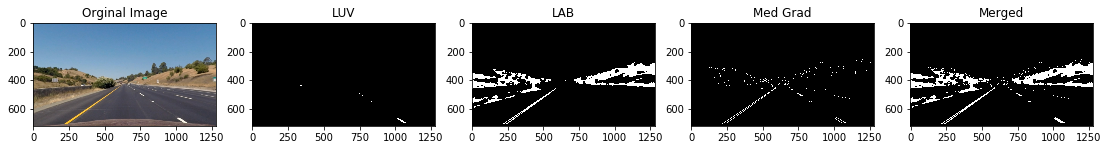

Lane width:  370.722182283
Radius:      1675354.49229
Car Dist:    -0.0545383840764


<Figure size 1368x576 with 0 Axes>

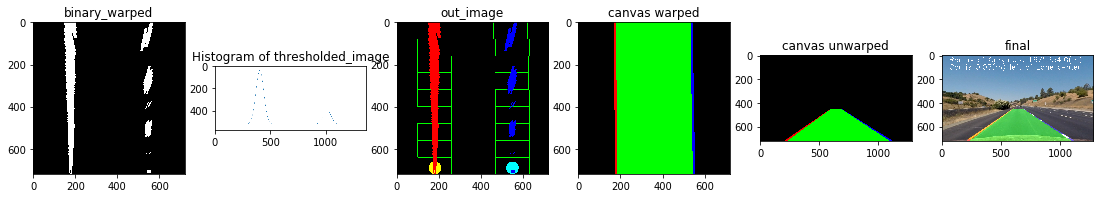

In [8]:
import glob

for img_fname in glob.glob(data_base_dir + "/test_images/straight_lines1.jpg"):
#for img_fname in glob.glob(data_base_dir + "/test_images/*.jpg"):
#for img_fname in glob.glob(data_base_dir + "/test_images/test1.jpg"):
#for img_fname in glob.glob("./challenge_video_frames/*.jpg"):
    print(img_fname)
    img = cv2.imread(img_fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lane_finding_pipeline(img, Frame(), visualize = True, log = True)

In [9]:
def process_video(imgFrame):
    global videoFrameObj
    global numberFrames
    
    videoFrameObj.verbose_log = True
    numberFrames += 1
    videoFrameObj.frameNum = numberFrames
    viz_cond = numberFrames >= 500 and numberFrames <= 600 and numberFrames % 1 == 0
    #viz_cond = numberFrames >= 0 and numberFrames <= 500 and numberFrames % 1 == 0
    visualize = True if (viz_cond) else False
    visualize = False
    
    if visualize:
        print("\n\n", numberFrames)
        videoFrameObj.verbose_log = True
    else:
        videoFrameObj.verbose_log = False
    
    try:
        return lane_finding_pipeline(imgFrame, videoFrameObj, visualize = visualize)
    except Exception as e:
        print("#" * 10, numberFrames, str(e), "#" * 10)
        raise Exception(e)
        # return imgFrame

In [10]:
videoFrameObj = Frame()
numberFrames = -1

#input_fileName = data_base_dir + "/test_videos/project_video_clipped.mp4"
#input_fileName = data_base_dir + "/test_videos/project_video_clipped_18_25.mp4"
#input_fileName = data_base_dir + "/test_videos/project_video_clipped_36_43.mp4"
input_fileName = data_base_dir + "/test_videos/project_video.mp4"

video = VideoFileClip(input_fileName, audio = False)
processed_video = video.fl_image(process_video)

#output_fileName = output_base_dir + "/output_videos/project_video_clipped.mp4"
#output_fileName = output_base_dir + "/output_videos/project_video_clipped_18_25.mp4"
#output_fileName = output_base_dir + "/output_videos/project_video_clipped_36_43.mp4"
output_fileName = output_base_dir + "/output_videos/project_video.mp4"

% time processed_video.write_videofile(output_fileName, audio = False)

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_fileName))

[MoviePy] >>>> Building video ./output/output_videos/project_video.mp4
[MoviePy] Writing video ./output/output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [01:38<00:00, 12.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/output_videos/project_video.mp4 

CPU times: user 4min 35s, sys: 1min 25s, total: 6min
Wall time: 1min 39s
